In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 24.1 MB/s eta 0:00:00


[fetch_haxby] Dataset found in /root/nilearn_data/haxby2001

/tmp/ipython-input-2083879659.py:45: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  X_all = masker.fit_transform(haxby.func[0])[mask]
/tmp/ipython-input-2083879659.py:45: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  X_all = masker.fit_transform(haxby.func[0])[mask]



🧠 PCA variance retained: 97.41%

📊 Fold-wise Accuracy
-----------------------------------
Fold 01: 96.30%
Fold 02: 100.00%
Fold 03: 100.00%
Fold 04: 92.59%
Fold 05: 100.00%
Fold 06: 100.00%
Fold 07: 100.00%
Fold 08: 100.00%
Fold 09: 96.30%
Fold 10: 92.59%
Fold 11: 88.89%
Fold 12: 92.59%

📈 Final Performance
-----------------------------------
Mean Accuracy : 96.60%
Std Deviation : 3.84%


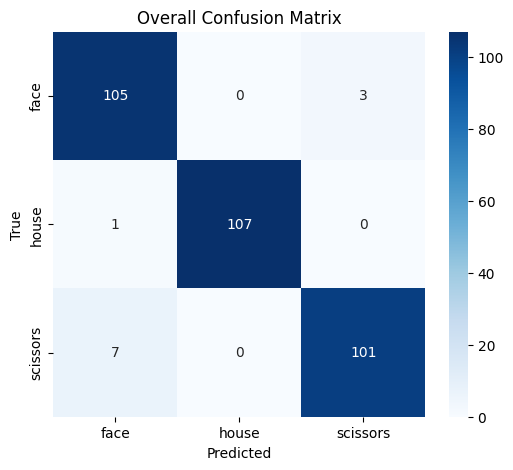

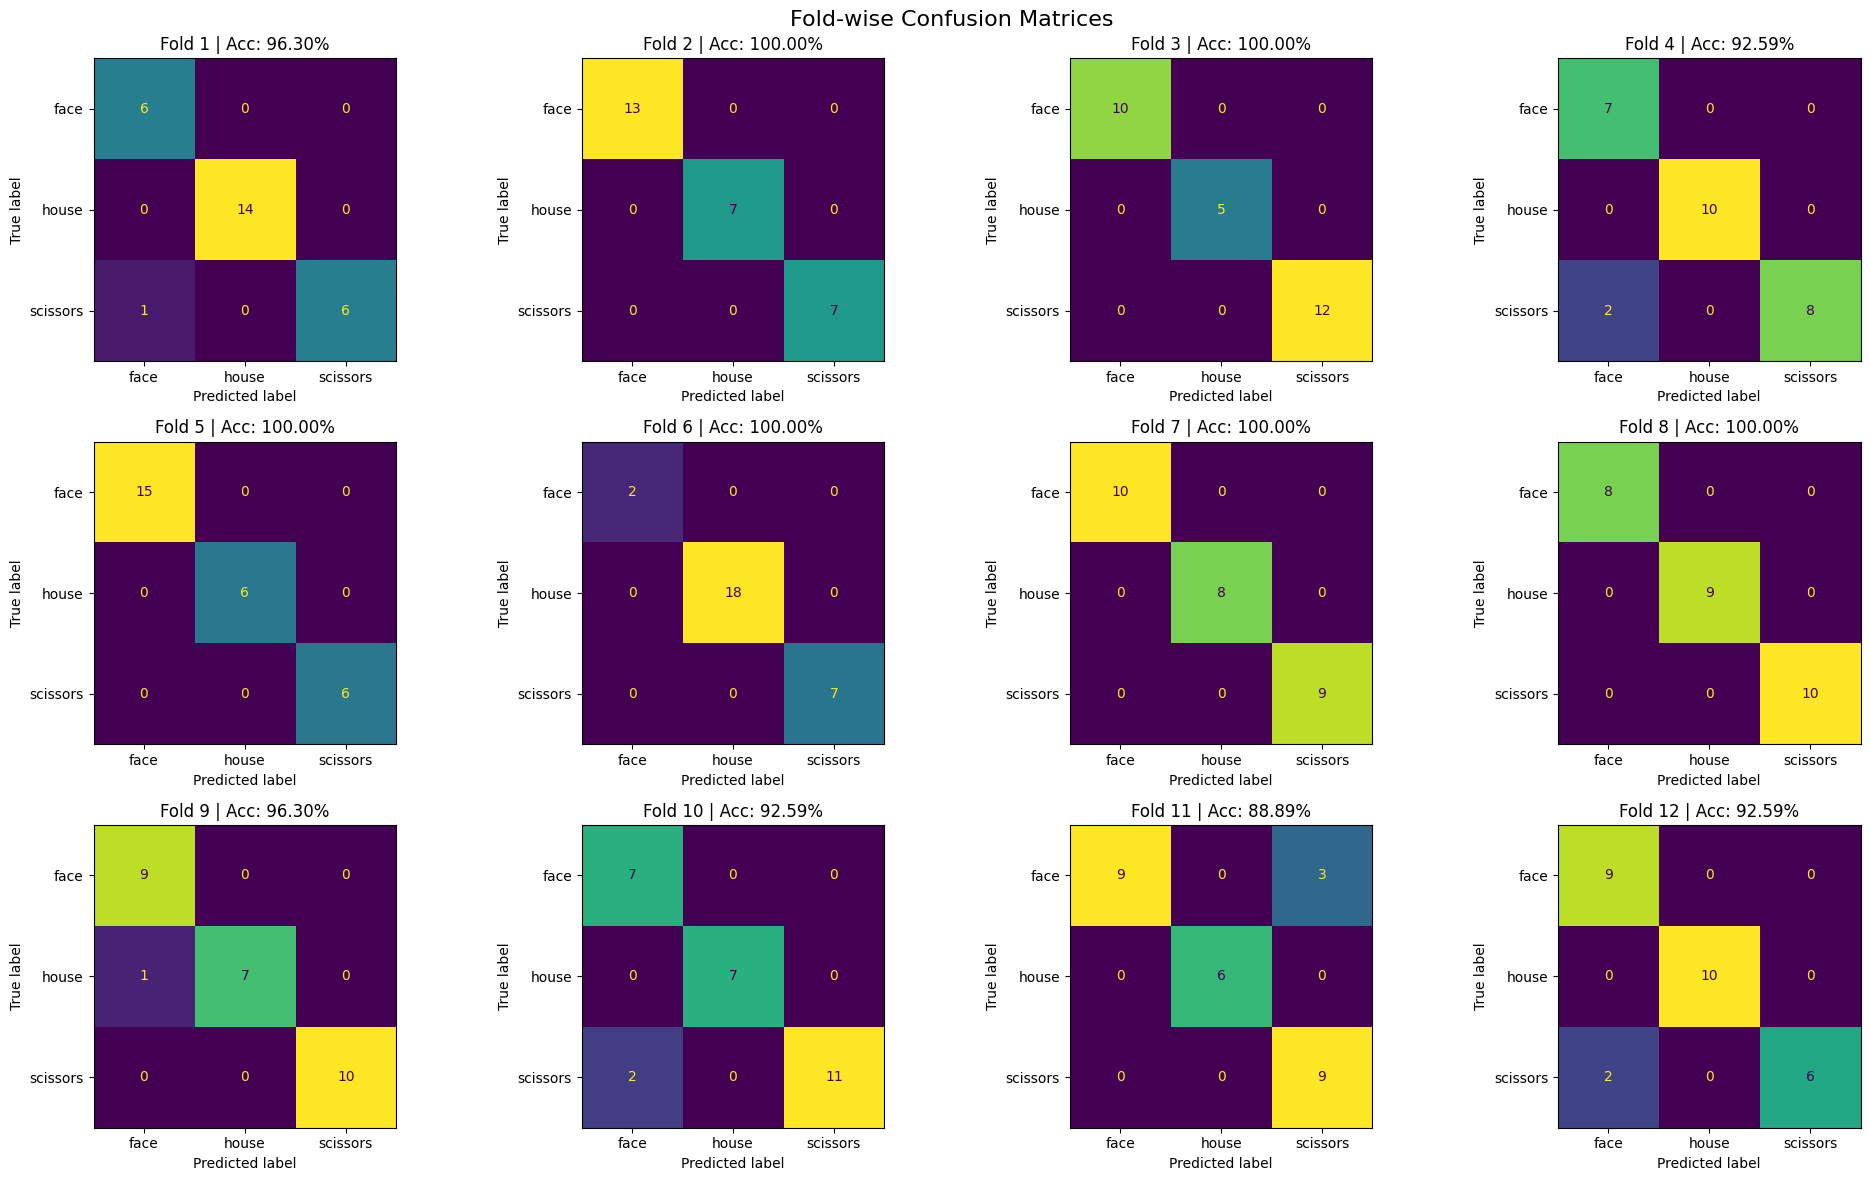

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import math

from nilearn import datasets, input_data
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ==============================
# Configuration
# ==============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_FOLDS = 12
EPOCHS = 25
BATCH_SIZE = 32
LR = 1e-3
DIFFUSION_STEPS = 100
PCA_COMPONENTS = 150
SAMPLES_PER_CLASS = 108

categories = ['face', 'house', 'scissors']
NUM_CLASSES = len(categories)

# ==============================
# Load Haxby Dataset
# ==============================
haxby = datasets.fetch_haxby()
masker = input_data.NiftiMasker(
    mask_img=haxby.mask_vt[0],
    standardize='zscore_sample'
)

labels_df = pd.read_csv(haxby.session_target[0], sep=' ')
mask = labels_df['labels'].isin(categories)
labels = labels_df.loc[mask, 'labels'].values

X_all = masker.fit_transform(haxby.func[0])[mask]

# ==============================
# Balance Classes
# ==============================
X_balanced, y_balanced = [], []

for i, cat in enumerate(categories):
    idx = np.where(labels == cat)[0][:SAMPLES_PER_CLASS]
    X_balanced.append(X_all[idx])
    y_balanced.append(np.full(SAMPLES_PER_CLASS, i))

X_balanced = np.vstack(X_balanced)
y_balanced = np.concatenate(y_balanced)

# ==============================
# PCA
# ==============================
X_scaled = StandardScaler().fit_transform(X_balanced)
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\n🧠 PCA variance retained: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# ==============================
# Diffusion Schedule (SAFE)
# ==============================
def cosine_beta_schedule(T, s=0.008):
    t = torch.linspace(0, T, T+1)
    f = torch.cos(((t / T) + s) / (1+s) * torch.pi / 2) ** 2
    f = f / f[0]
    betas = 1 - (f[1:] / f[:-1])
    return betas.clamp(1e-4, 0.999)

betas = cosine_beta_schedule(DIFFUSION_STEPS).to(DEVICE)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

sqrt_alpha = torch.sqrt(alphas_cumprod)
sqrt_one_minus = torch.sqrt(1 - alphas_cumprod)

def forward_diffusion(x, t):
    noise = torch.randn_like(x)
    return (
        sqrt_alpha[t][:, None] * x +
        sqrt_one_minus[t][:, None] * noise,
        noise
    )

# ==============================
# Model
# ==============================
class DenoiseMLP(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )
        self.noise_head = nn.Linear(512, dim)
        self.class_head = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.backbone(x)
        return self.noise_head(h), self.class_head(h)

# ==============================
# Cross-Validation
# ==============================
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

fold_accs = []
fold_cms = []
y_all_pred, y_all_true = [], []

print("\n📊 Fold-wise Accuracy")
print("-" * 35)

for fold, (tr, te) in enumerate(kf.split(X_pca), 1):

    X_train = torch.tensor(X_pca[tr], dtype=torch.float32).to(DEVICE)
    y_train = torch.tensor(y_balanced[tr]).to(DEVICE)
    X_test  = torch.tensor(X_pca[te], dtype=torch.float32).to(DEVICE)
    y_test  = y_balanced[te]

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True)

    model = DenoiseMLP(PCA_COMPONENTS, NUM_CLASSES).to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR)

    mse = nn.MSELoss()
    ce  = nn.CrossEntropyLoss()

    # -------- Training --------
    model.train()
    for _ in range(EPOCHS):
        for xb, yb in loader:
            t = torch.randint(0, DIFFUSION_STEPS, (xb.size(0),), device=DEVICE)
            x_noisy, noise = forward_diffusion(xb, t)
            pred_noise, logits = model(x_noisy)

            loss = 0.7 * mse(pred_noise, noise) + 0.3 * ce(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    # -------- Evaluation (CLEAN INPUT) --------
    model.eval()
    with torch.no_grad():
        _, logits = model(X_test)
        y_pred = logits.argmax(1).cpu().numpy()

    acc = accuracy_score(y_test, y_pred)
    fold_accs.append(acc)
    fold_cms.append(confusion_matrix(y_test, y_pred))
    y_all_pred.extend(y_pred)
    y_all_true.extend(y_test)

    print(f"Fold {fold:02d}: {acc*100:.2f}%")

# ==============================
# Final Metrics
# ==============================
mean_acc = np.mean(fold_accs)
std_acc  = np.std(fold_accs)

print("\n📈 Final Performance")
print("-" * 35)
print(f"Mean Accuracy : {mean_acc*100:.2f}%")
print(f"Std Deviation : {std_acc*100:.2f}%")

# ==============================
# Overall Confusion Matrix
# ==============================
plt.figure(figsize=(6,5))
sns.heatmap(
    confusion_matrix(y_all_true, y_all_pred),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=categories, yticklabels=categories
)
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ==============================
# Fold-wise Confusion Matrices
# ==============================
cols = 4
rows = math.ceil(NUM_FOLDS / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, cm in enumerate(fold_cms):
    disp = ConfusionMatrixDisplay(cm, display_labels=categories)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"Fold {i+1} | Acc: {fold_accs[i]*100:.2f}%")

for j in range(NUM_FOLDS, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Fold-wise Confusion Matrices", fontsize=16)
plt.tight_layout()
plt.show()


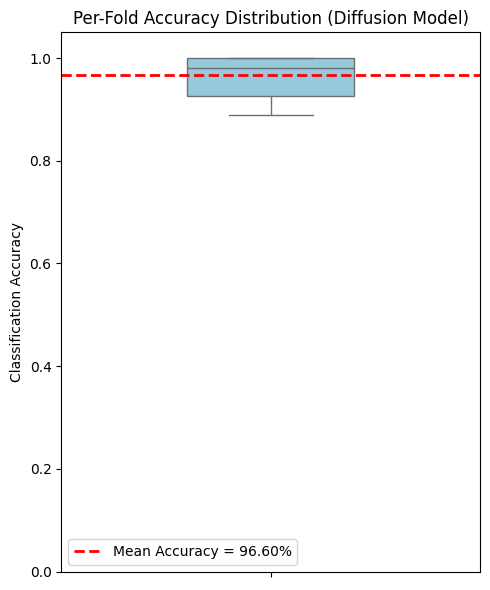

In [23]:
# -----------------------------
# Box plot of per-fold accuracy (Diffusion Model)
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# fold_accs is already collected during CV for DM
fold_accs_np = np.array(fold_accs)  # ensure it's a NumPy array

plt.figure(figsize=(5, 6))

sns.boxplot(
    y=fold_accs_np,
    width=0.4,
    showfliers=True,
    color='skyblue'
)

# Mean accuracy (dotted red line)
mean_acc = np.mean(fold_accs_np)
plt.axhline(
    mean_acc,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean Accuracy = {mean_acc*100:.2f}%"
)

plt.ylabel("Classification Accuracy")
plt.title("Per-Fold Accuracy Distribution (Diffusion Model)")
plt.ylim(0, 1.05)  # optional: keep y-axis in [0,1] range
plt.legend()
plt.tight_layout()
plt.show()


[fetch_haxby] Dataset found in /root/nilearn_data/haxby2001

/tmp/ipython-input-736938933.py:50: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  X_all = masker.fit_transform(haxby.func[0])[condition_mask]
/tmp/ipython-input-736938933.py:50: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  X_all = masker.fit_transform(haxby.func[0])[condition_mask]
/tmp/ipython-input-736938933.py:50: FutureWarning: The 'zscore' strategy incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the 'zscore' option will be removed and using standardize=True will fall back to 'zscore_sample'.To avoid this warning, please use 'zscore_sample' instead.
  X_all = masker.fit_transform(haxby.func[0])[condition_mask]



================ face vs house =================
Samples per class: 108
  Fold 1/12
    Accuracy: 100.00%
  Fold 2/12
    Accuracy: 100.00%
  Fold 3/12
    Accuracy: 100.00%
  Fold 4/12
    Accuracy: 100.00%
  Fold 5/12
    Accuracy: 100.00%
  Fold 6/12
    Accuracy: 100.00%
  Fold 7/12
    Accuracy: 100.00%
  Fold 8/12
    Accuracy: 100.00%
  Fold 9/12
    Accuracy: 100.00%
  Fold 10/12
    Accuracy: 100.00%
  Fold 11/12
    Accuracy: 100.00%
  Fold 12/12
    Accuracy: 100.00%

📈 Mean Accuracy: 100.00% ± 0.00%


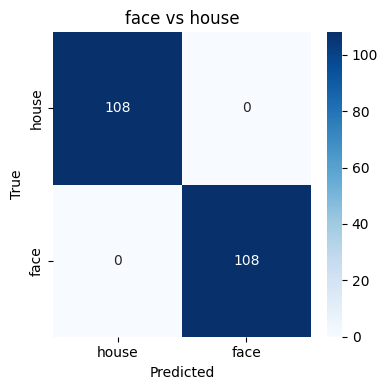


================ face vs scissors =================
Samples per class: 108
  Fold 1/12
    Accuracy: 100.00%
  Fold 2/12
    Accuracy: 100.00%
  Fold 3/12
    Accuracy: 94.44%
  Fold 4/12
    Accuracy: 94.44%
  Fold 5/12
    Accuracy: 100.00%
  Fold 6/12
    Accuracy: 94.44%
  Fold 7/12
    Accuracy: 100.00%
  Fold 8/12
    Accuracy: 100.00%
  Fold 9/12
    Accuracy: 94.44%
  Fold 10/12
    Accuracy: 88.89%
  Fold 11/12
    Accuracy: 100.00%
  Fold 12/12
    Accuracy: 100.00%

📈 Mean Accuracy: 97.22% ± 3.59%


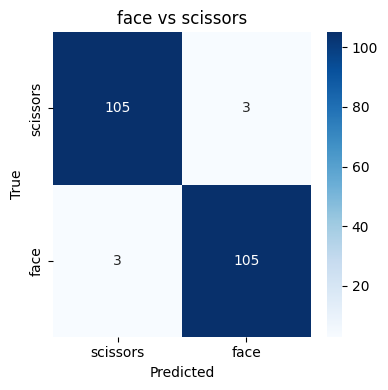


================ house vs scissors =================
Samples per class: 108
  Fold 1/12
    Accuracy: 100.00%
  Fold 2/12
    Accuracy: 100.00%
  Fold 3/12
    Accuracy: 100.00%
  Fold 4/12
    Accuracy: 100.00%
  Fold 5/12
    Accuracy: 94.44%
  Fold 6/12
    Accuracy: 100.00%
  Fold 7/12
    Accuracy: 100.00%
  Fold 8/12
    Accuracy: 100.00%
  Fold 9/12
    Accuracy: 100.00%
  Fold 10/12
    Accuracy: 100.00%
  Fold 11/12
    Accuracy: 100.00%
  Fold 12/12
    Accuracy: 100.00%

📈 Mean Accuracy: 99.54% ± 1.54%


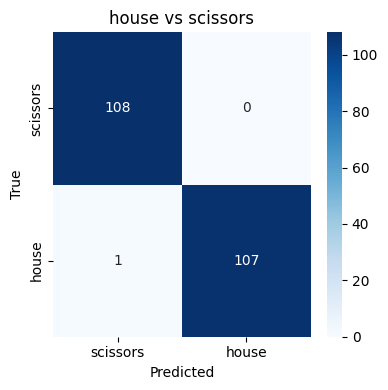

In [25]:
# ============================================================
# Pairwise Diffusion-Based Classification on Haxby Dataset
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from nilearn import datasets, input_data
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import combinations

# ==============================
# Configuration
# ==============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_FOLDS = 12
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
DIFFUSION_STEPS = 100
PCA_COMPONENTS = 150
SAMPLES_PER_CLASS = 108

categories = ['face', 'house', 'scissors']

# ==============================
# Load Haxby Dataset
# ==============================
haxby = datasets.fetch_haxby()
mask_filename = haxby.mask_vt[0]

labels_df = pd.read_csv(haxby.session_target[0], sep=' ')
condition_mask = labels_df['labels'].isin(categories)

labels = labels_df.loc[condition_mask, 'labels'].values

# ==============================
# fMRI Masking
# ==============================
masker = input_data.NiftiMasker(mask_img=mask_filename, standardize=True)
X_all = masker.fit_transform(haxby.func[0])[condition_mask]

# ============================================================
# Diffusion Utilities
# ============================================================
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

betas = cosine_beta_schedule(DIFFUSION_STEPS).to(DEVICE)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    return (
        sqrt_alphas_cumprod[t].unsqueeze(1) * x0 +
        sqrt_one_minus_alphas_cumprod[t].unsqueeze(1) * noise,
        noise
    )

# ============================================================
# Model
# ============================================================
class DenoiseMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )
        self.denoise_head = nn.Linear(512, input_dim)
        self.class_head = nn.Linear(512, 2)  # BINARY

    def forward(self, x):
        f = self.shared(x)
        return self.denoise_head(f), self.class_head(f)

# ============================================================
# Pairwise Classification
# ============================================================
pairs = list(combinations(categories, 2))

for class_a, class_b in pairs:
    print(f"\n================ {class_a} vs {class_b} =================")

    # Select pair
    mask = np.isin(labels, [class_a, class_b])
    X_pair = X_all[mask]
    y_pair = labels[mask]

    # Binary labels
    y_pair = (y_pair == class_a).astype(int)

    # Balance classes
    n_min = min(np.sum(y_pair == 0), np.sum(y_pair == 1))
    idx0 = np.where(y_pair == 0)[0][:n_min]
    idx1 = np.where(y_pair == 1)[0][:n_min]
    idx = np.concatenate([idx0, idx1])

    X_pair = X_pair[idx]
    y_pair = y_pair[idx]

    print(f"Samples per class: {n_min}")

    # Standardization + PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pair)

    pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Cross-validation
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

    fold_accuracies = []
    y_preds, y_trues = [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_pca)):
        print(f"  Fold {fold+1}/{NUM_FOLDS}")

        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y_pair[train_idx], y_pair[test_idx]

        train_ds = torch.utils.data.TensorDataset(
            torch.FloatTensor(X_train),
            torch.LongTensor(y_train)
        )

        train_loader = torch.utils.data.DataLoader(
            train_ds, batch_size=BATCH_SIZE, shuffle=True
        )

        model = DenoiseMLP(X_train.shape[1]).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        mse_loss = nn.MSELoss()
        ce_loss = nn.CrossEntropyLoss()

        # Training
        for epoch in range(EPOCHS):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                t = torch.randint(0, DIFFUSION_STEPS, (xb.size(0),), device=DEVICE)

                noisy_x, noise = forward_diffusion(xb, t)
                pred_noise, logits = model(noisy_x)

                loss = 0.7 * mse_loss(pred_noise, noise) + \
                       0.3 * ce_loss(logits, yb)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            logits = model(torch.FloatTensor(X_test).to(DEVICE))[1]
            y_pred = torch.argmax(logits, dim=1).cpu().numpy()

        acc = accuracy_score(y_test, y_pred)
        fold_accuracies.append(acc)

        y_preds.extend(y_pred)
        y_trues.extend(y_test)

        print(f"    Accuracy: {acc*100:.2f}%")

    # Results
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)

    print(f"\n📈 Mean Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_trues, y_preds)

    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[class_b, class_a],
        yticklabels=[class_b, class_a]
    )
    plt.title(f"{class_a} vs {class_b}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
